In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tqdm
import time 
import json
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess
import argparse
import pandas as pd
import shutil

import torch
print("CUDA available: ", torch.cuda.is_available())
gpu_name = torch.cuda.get_device_name(0)
print("GPU name: ", gpu_name)

# Change the current working directory to the directory where this notebook is located
notebook_path = os.path.abspath("../")
os.chdir(notebook_path)
print("Current working directory changed to:", os.getcwd())
from mvtorch.data import ScanObjectNN, CustomDataLoader, ModelNet40
from mvtorch.networks import MVNetwork
from mvtorch.view_selector import MVTN
from mvtorch.mvrenderer import MVRenderer
from earlyStop import EarlyStopping

/home/mpelissi/anaconda3/envs/MVTN_env3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available:  True
GPU name:  Quadro RTX 5000
Current working directory changed to: /home/mpelissi/MVTN/my_MVTN


In [2]:
nb_views = 12
epochs = 10
bs = 4
data_dir = "/home/mpelissi/Dataset/ModelNet40/"
category = "all"
views_config = "circular"

In [3]:
# For a specific file, use:
name_file = "airplane_0628"

In [4]:
# Number of samples to load per class (for faster experimentation)
samples_per_class_train = None  # Adjust this number as needed
samples_per_class_test = None # Adjust this number as needed
## Data loading
dset_train = ModelNet40(data_dir=data_dir, split='train', samples_per_class=samples_per_class_train, category=category, simplified_mesh=True)
dset_test = ModelNet40(data_dir=data_dir, split='test', samples_per_class=samples_per_class_test, category=category, simplified_mesh=True)
print(f"🔎​​​ Which categories are used ? 🚨​ {category} 🚨​\n")
## Optimize code 1/3
train_loader = CustomDataLoader(dset_train, batch_size=bs, shuffle=True, drop_last=False, pin_memory=True)
test_loader = CustomDataLoader(dset_test, batch_size=bs, shuffle=False, drop_last=False, pin_memory=True)
print((f"📦​ There are {len(train_loader)} batches of {bs} samples in the training set"))
print((f"📦 ​There are {len(test_loader)} batches of {bs} samples in the testing set"))

🔎​​​ Which categories are used ? 🚨​ all 🚨​

📦​ There are 2461 batches of 4 samples in the training set
📦 ​There are 617 batches of 4 samples in the testing set


In [5]:
## Network initialization
# Create backbone multi-view network (ResNet18)
mvnetwork = MVNetwork(num_classes=len(dset_train.classes), num_parts=None, mode='cls', net_name='resnet18').cuda()

# Create backbone optimizer
weight_decay = 0.03  # Adjust weight decay as needed
lr_opti = 0.00001
optimizer = torch.optim.AdamW(mvnetwork.parameters(), lr=lr_opti, weight_decay=weight_decay)

# Create view selector
mvtn = MVTN(nb_views, views_config, canonical_distance=1.1*2).cuda()
print(f"🔍​ View selector configuration: {views_config} with {nb_views} views")

# Create optimizer for view selector (In case views are not fixed, otherwise set to None)
if 'learned' in views_config:
    print("Using learned view selector")
    lr_mvtn_optimizer = 0.0001
    mvtn_optimizer = torch.optim.AdamW(mvtn.parameters(), lr=lr_mvtn_optimizer, weight_decay=weight_decay)
    opti_mvtn = 'setup'
else :
    print("mvtn_optimizer is None !!!!!")
    mvtn_optimizer = None
    opti_mvtn = None
    lr_mvtn_optimizer = None         

# Create multi-view renderer
mvrenderer = MVRenderer(nb_views=nb_views, return_mapping=False, pc_rendering=False)
# Create loss function for training
criterion = torch.nn.CrossEntropyLoss()
# Create early stopping mechanism
patience = 10; min_delta = 0.001
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

Using cache found in /home/mpelissi/.cache/torch/hub/pytorch_vision_v0.8.2


🔍​ View selector configuration: circular with 12 views
mvtn_optimizer is None !!!!!


In [6]:
for i, (targets, meshes, points, names) in enumerate(test_loader):
    if name_file is not None: #Affichage d'un fichier en particulier"
        if any([name_file in p for p in names]) :  # si le fichier recherché est dans le batch
            print(f"Found {name_file} in batch {i}")
            azim, elev, dist = mvtn(points, c_batch_size=len(targets))
            rendered_images, _ = mvrenderer(meshes, points, azim=azim, elev=elev, dist=dist)
            pos_name_file = names.index(next(p for p in names if name_file in p))
            break
        else : continue 
        
    else :
        azim, elev, dist = mvtn(points, c_batch_size=len(targets))
        print(azim, elev, dist)
        rendered_images, _ = mvrenderer(meshes, points, azim=azim, elev=elev, dist=dist)
        if i == 0:
            print(f"Rendered images shape: {rendered_images.shape}")
            print(f"Targets shape: {targets.shape}")
            print(f"Points shape: {points.shape}")
            print(f"Names: {names}")
            break

print("Fin", azim, elev, dist)

Found airplane_0628 in batch 0
Fin tensor([[-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.],
        [-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.],
        [-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.],
        [-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.]], device='cuda:0') tensor([[30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.],
        [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.],
        [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.],
        [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.]],
       device='cuda:0') tensor([[2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000,
         2.2000, 2.2000, 2.2000],
        [2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000,
         2.2000, 2.2000, 2.2000],


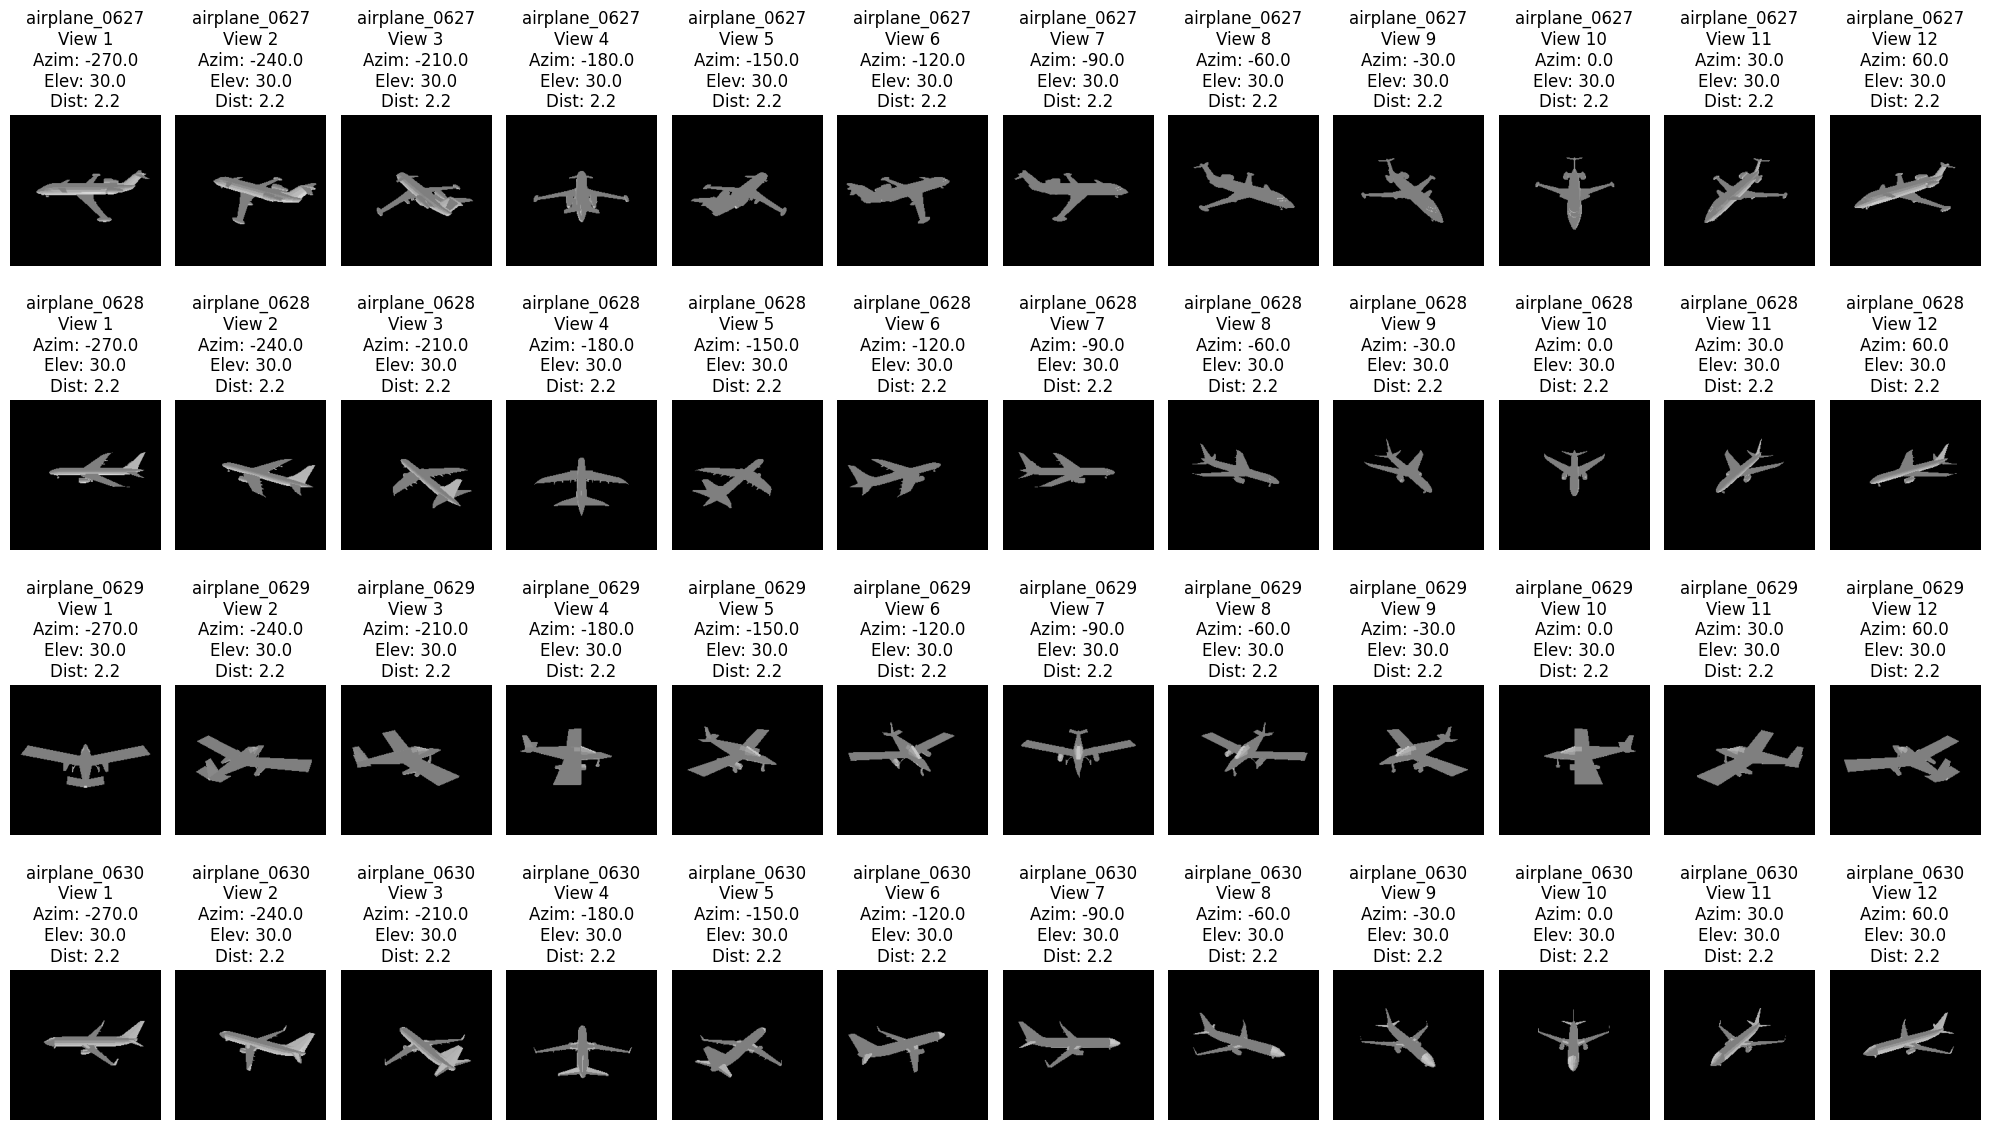

In [7]:
# Create a figure with subplots for each view
fig, axes = plt.subplots(bs, nb_views, figsize=(20, 12))

# Iterate through the batch (2 objects)
for i in range(bs):
    for j in range(nb_views):
        ax = axes[i, j]
        # Get image from rendered_images and move to CPU, take first 3 channels
        img = rendered_images[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        ax.imshow(img, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'{os.path.basename(names[i].split("_SM")[0])}\nView {j+1}\nAzim: {azim[i,j]:.1f}\nElev: {elev[i,j]:.1f}\nDist: {dist[i,j]:.1f}')
        #cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[i, j], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()

torch.Size([4, 12, 3, 224, 224])
torch.Size([4, 12, 3, 224, 224])


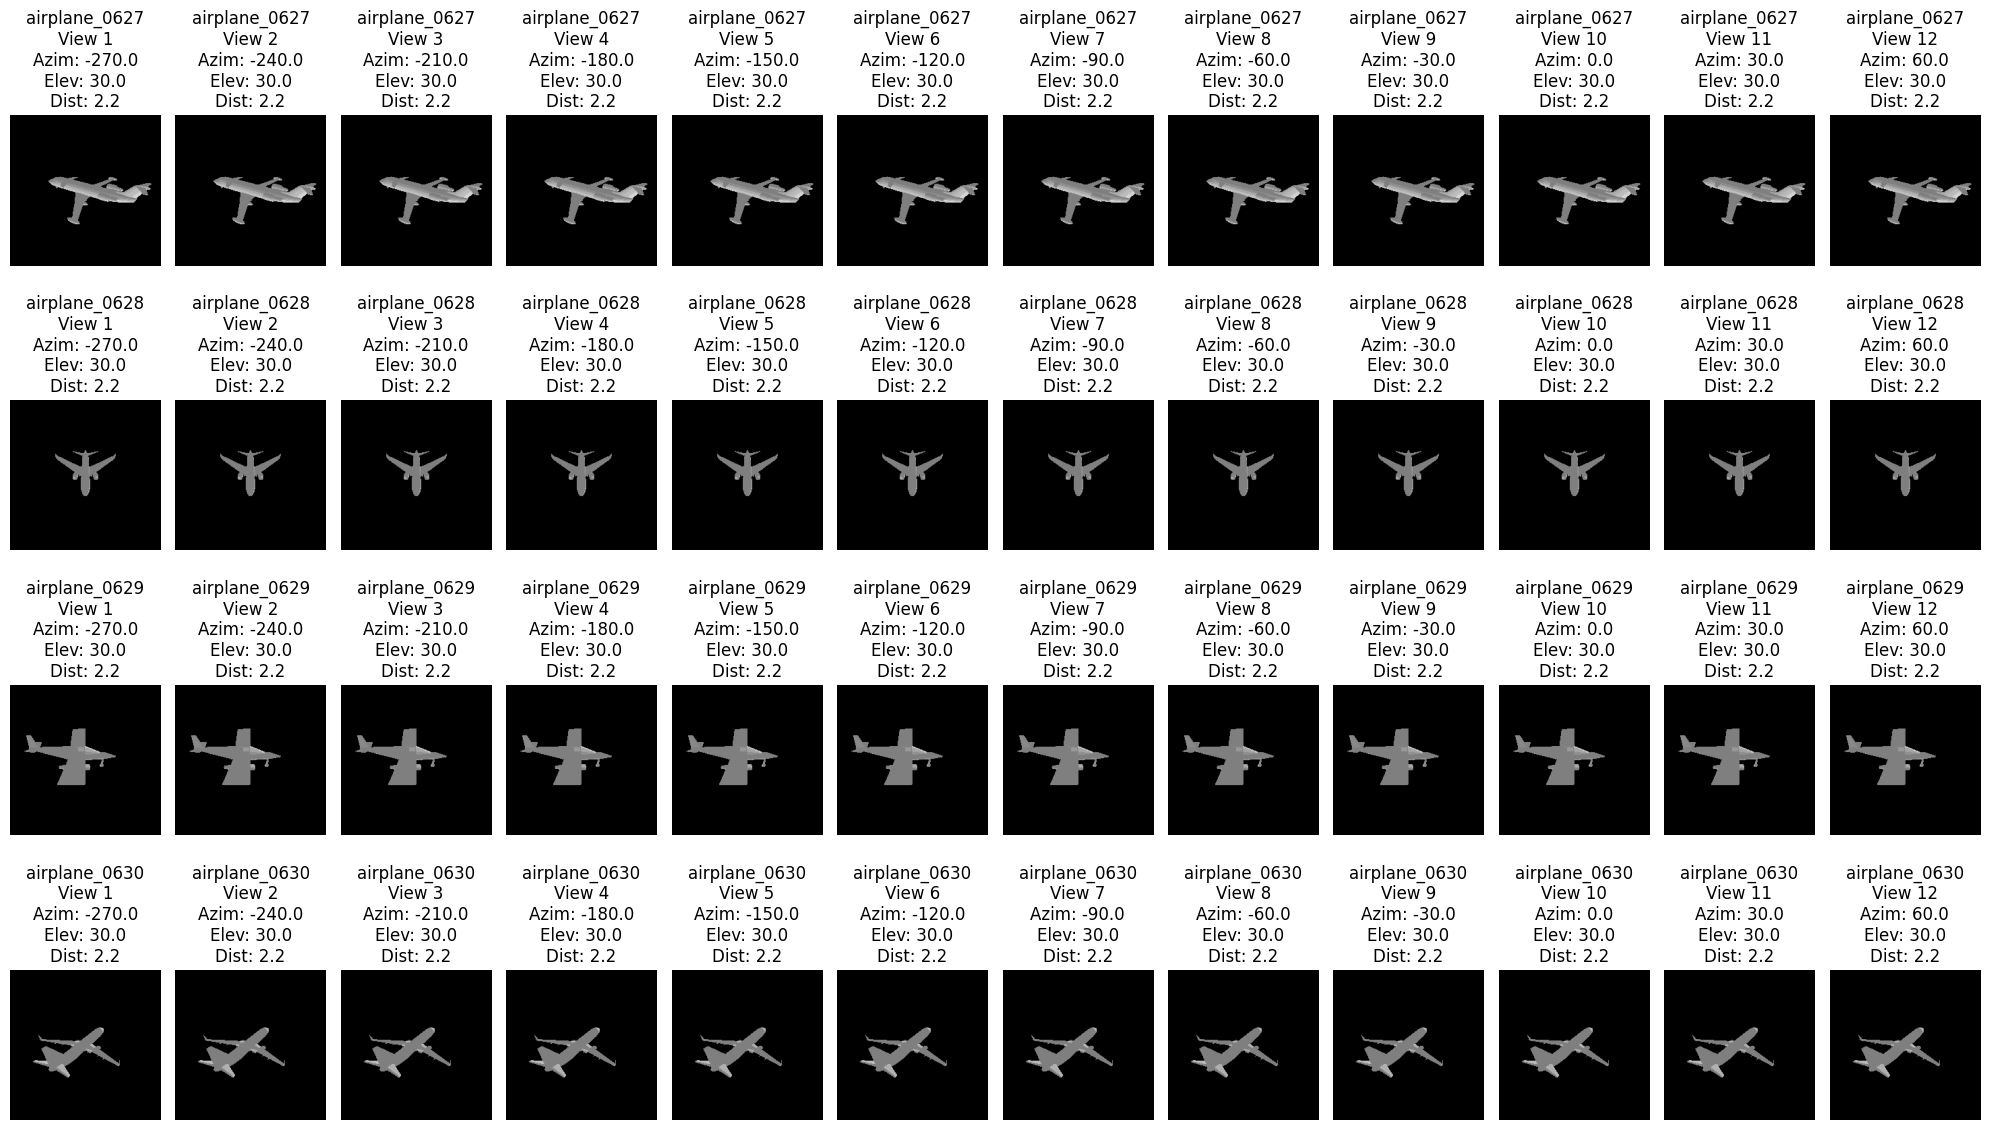

In [ ]:
print(rendered_images.shape)
toto = [1,9,3,4] # pour vue 10
replicated_tensor = torch.empty_like(rendered_images)

for group_idx, pov_index in enumerate(toto):
    selected_image = rendered_images[group_idx, pov_index]  # shape: [3, 224, 224]
    # replicate this image 12 times along dimension 0
    replicated_tensor[group_idx] = selected_image.unsqueeze(0).expand(12, -1, -1, -1)
    
print(replicated_tensor.shape)

# Create a figure with subplots for each view
fig, axes = plt.subplots(bs, nb_views, figsize=(20, 12))

# Iterate through the batch (2 objects)
for i in range(bs):
    for j in range(nb_views):
        ax = axes[i, j]
        # Get image from rendered_images and move to CPU, take first 3 channels
        img = replicated_tensor[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        ax.imshow(img, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'{os.path.basename(names[i].split("_SM")[0])}\nView {j+1}\nAzim: {azim[i,j]:.1f}\nElev: {elev[i,j]:.1f}\nDist: {dist[i,j]:.1f}')
        #cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[i, j], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()

In [ ]:
points.shape